# Network traffic analysis on IoT devices



### Import section

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns

## Firstlook at data

In [2]:
# Define paths
data_path = Path('data')
output_path = Path('output')
file_names = ['iot_device_test.csv', 'iot_device_train.csv']

In [3]:
# Read data
trainset, testset = pd.read_csv(data_path / file_names[0]), pd.read_csv(data_path / file_names[1])

In [5]:
# Check the class distribution for each file
target_column = "device_category"
print(" Trainset ".center(30, "="))
print(trainset[target_column].value_counts())
print(" Testset ".center(30, "="))
print(testset[target_column].value_counts())

train_labels = set(trainset[target_column].unique())
test_labels = set(testset[target_column].unique())
print()
print(f"Difference between test and train labels: {test_labels.difference(train_labels)}")

========== Trainset ==========
device_category
baby_monitor       100
lights             100
motion_sensor      100
security_camera    100
smoke_detector     100
socket             100
thermostat         100
TV                 100
watch              100
Name: count, dtype: int64
========== Testset ===========
device_category
security_camera    100
TV                 100
smoke_detector     100
thermostat         100
water_sensor       100
watch              100
baby_monitor       100
motion_sensor      100
lights             100
socket             100
Name: count, dtype: int64

Difference between test and train labels: {'water_sensor'}


Como podemos ver as classes estão bem balanceadas em ambos conjuntos, com quantidade definida de **100** amostras por classe. Entratanto, há uma pequena alteração em do conjunto de treino em relação ao conjunto de teste, a classes `water_sensor` que está ausente no cojunto de treino. Dessa forma, temos 2 abordagens possíveis:
1. Eliminar essa classes do conjunto de teste, o que implicaria na perda de dados o que deve ser evitado
2. Distribuir essa classe para o cojunto de treino garantindo que não haja vazamento de treino e teste  


Outro ponto que podemos notar é que há `297` features no total, podemos então analisar os dados com o objetivo de fazer o pré-processamento com o objetivo de identificar possíveis features que não sejam relevantes ou com alta correlação com outra, para assim, excluirmos elas e diminuir a complexidade do treino.

In [6]:
# Unify the data in a single object
dataset = pd.concat([trainset, testset])

#### Distribuição das classes após junção dos arquivos

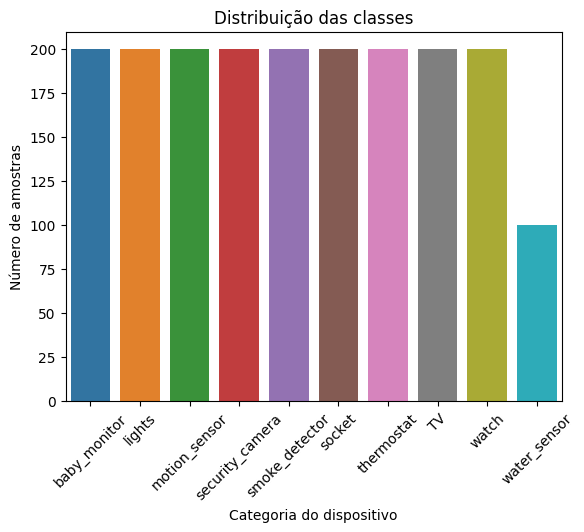

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(dataset, x="device_category")
plt.xticks(rotation=45)
plt.title("Distribuição das classes")
plt.xlabel("Categoria do dispositivo")
plt.ylabel("Número de amostras")
plt.show()

## Pré-processamento
### Remove colunas com mais de 50% dos valores faltantes

In [8]:
# Remove columns with more than 50% of missing values
dataset_nona = dataset.dropna(axis='columns', thresh=0.5)

# Check if any column has at least one missing case
print(any(dataset_nona.isna().mean() > 0))

False


Como podemos ver nenhua coluna foi descartada por esse critério, apesar de que, na realidade, nenhuma coluna apresentou dados faltantes.

### Remove as características fortemente correlacionadas

<Axes: >

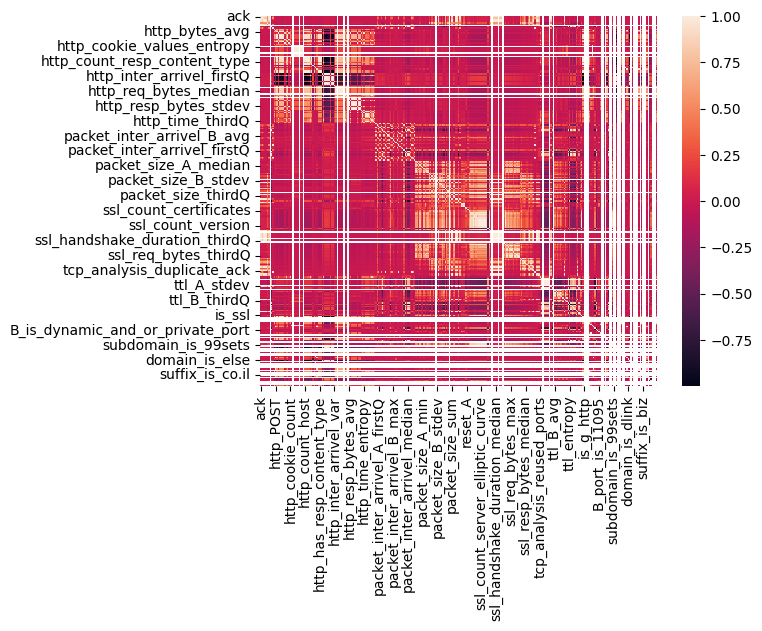

In [9]:
# Plot the correlation matrix
dataset_corr = dataset_nona.select_dtypes('number').corr()
sns.heatmap(dataset_corr)

Pode-se constatar que há regiões onde há uma grande correlação das características, dessa forma, torna-se necessário remover essa features para
evitar-se o [mal da dimensionalidade](https://en.wikipedia.org/wiki/Curse_of_dimensionality).  
A remoção de variáveis foi feita da seguinte forma:
1. Seleciona os pares de variáveis com correlação acima de `90%`
2. Remove a variável com menor correlação com a classe

In [10]:
# Source https://stackoverflow.com/a/61938339/14045774
from sklearn.preprocessing import LabelEncoder

def remove_collinear_features(df : pd.DataFrame, target : str, threshold : float ):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        df: full dataframe
        target: column name of the target variable
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Categorize the labels
    le = LabelEncoder()
    le.fit(df[target])
    df[target] = le.transform(df[target])
    # Compute the correlation between features and target
    target_corr = df.corr()[target].abs()
    
    # Calculate the correlation matrix
    features_df = df.loc[:, df.columns != target]
    corr_matrix = features_df.corr().abs()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                # Add the feature with least correlation with target
                if (target_corr[col.values[0]] < target_corr[row.values[0]]):
                    drop_cols.append(col.values[0])
                else:
                    drop_cols.append(row.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    # Go back to target names
    df = df.drop(columns=drops)
    df[target] = le.inverse_transform(df[target])

    return df

dataset_dropped = remove_collinear_features(dataset_nona, "device_category", 0.9)
dataset_dropped.head()

,bytes_A_B_ratio,ds_field_A,http_GET,http_bytes_avg,http_bytes_sum,http_cookie_values_entropy,http_cookie_values_stdev,http_cookie_values_var,http_dom_host_alexaRank,http_dom_resp_code,...,suffix_is_co.il,suffix_is_com,suffix_is_com.sg,suffix_is_else,suffix_is_empty_char_value,suffix_is_googleapis.com,suffix_is_net,suffix_is_org,suffix_is_unresolved,device_category
0,1.135096,0,0,0.0,0,0,0,0,2147483647,0,...,0,0,0,1,0,0,0,0,0,baby_monitor
1,1.135096,0,0,0.0,0,0,0,0,2147483647,0,...,0,0,0,1,0,0,0,0,0,baby_monitor
2,1.124640,0,0,0.0,0,0,0,0,2147483647,0,...,0,0,0,1,0,0,0,0,0,baby_monitor
3,1.124640,0,0,0.0,0,0,0,0,2147483647,0,...,0,0,0,1,0,0,0,0,0,baby_monitor
4,1.163949,0,0,0.0,0,0,0,0,2147483647,0,...,0,0,0,1,0,0,0,0,0,baby_monitor


### Padroniza os dados numéricos
Para os dados numéricos foi aplicado o `StandardScaler` que padronizao os valores no intervalo `[0, 1]`

In [11]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
columns_numeric = dataset_dropped.select_dtypes('number').columns
dataset_cleaned = dataset_dropped.copy(deep=True)
dataset_cleaned[columns_numeric] = std_scaler.fit_transform(dataset_dropped[columns_numeric])
dataset_cleaned.head()

,bytes_A_B_ratio,ds_field_A,http_GET,http_bytes_avg,http_bytes_sum,http_cookie_values_entropy,http_cookie_values_stdev,http_cookie_values_var,http_dom_host_alexaRank,http_dom_resp_code,...,suffix_is_co.il,suffix_is_com,suffix_is_com.sg,suffix_is_else,suffix_is_empty_char_value,suffix_is_googleapis.com,suffix_is_net,suffix_is_org,suffix_is_unresolved,device_category
0,-0.013369,0.0,-0.308384,-0.354443,-0.229085,0.0,0.0,0.0,0.089205,-0.293134,...,0.0,-0.140927,0.0,0.894004,-0.684336,0.0,0.0,0.0,-0.215071,baby_monitor
1,-0.013369,0.0,-0.308384,-0.354443,-0.229085,0.0,0.0,0.0,0.089205,-0.293134,...,0.0,-0.140927,0.0,0.894004,-0.684336,0.0,0.0,0.0,-0.215071,baby_monitor
2,-0.016377,0.0,-0.308384,-0.354443,-0.229085,0.0,0.0,0.0,0.089205,-0.293134,...,0.0,-0.140927,0.0,0.894004,-0.684336,0.0,0.0,0.0,-0.215071,baby_monitor
3,-0.016377,0.0,-0.308384,-0.354443,-0.229085,0.0,0.0,0.0,0.089205,-0.293134,...,0.0,-0.140927,0.0,0.894004,-0.684336,0.0,0.0,0.0,-0.215071,baby_monitor
4,-0.005069,0.0,-0.308384,-0.354443,-0.229085,0.0,0.0,0.0,0.089205,-0.293134,...,0.0,-0.140927,0.0,0.894004,-0.684336,0.0,0.0,0.0,-0.215071,baby_monitor


## Treinamento

Divide o dataset em características `X` e as classes `y`

In [12]:
# Divide the dataset into features (X) and target (y)
X, y = dataset_cleaned.loc[:, dataset_cleaned.columns != "device_category"], dataset_cleaned.loc[:, "device_category"]

Checa o desempenho de cada classificador no dataset separadamente

In [13]:
# Get a glimpse at each classifier performance separeted
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier

le = LabelEncoder()
le.fit(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)  # Fix random_state to make deterministic
y_test_encoded = le.transform(y_test)
y_train_encoded = le.transform(y_train)

xgb = XGBClassifier(
    #kwargs={'selector__threshold': 0, 'classifier__n_estimators': 400, 'classifier__min_child_weight': 8, 'classifier__max_depth': 6, 'classifier__eta': 0.1},
    n_estimators=8, max_depth=2, learning_rate=1, 
    objective='multi:softmax')

#xgb = RandomForestClassifier() 
#xgb = AdaBoostClassifier(estimator=rf)
#xgb = GradientBoostingClassifier()
#xgb = BaggingClassifier()

xgb.fit(X_train, y_train_encoded)

y_pred = xgb.predict(X_test)

print(classification_report(y_test_encoded, y_pred, target_names=y.unique()))

                 precision    recall  f1-score   support

   baby_monitor       0.89      0.90      0.89        60
         lights       1.00      0.93      0.97        60
  motion_sensor       0.60      0.68      0.64        60
security_camera       1.00      0.93      0.97        60
 smoke_detector       0.92      1.00      0.96        60
         socket       0.97      1.00      0.98        60
     thermostat       0.59      0.68      0.63        60
             TV       0.97      1.00      0.98        60
          watch       0.93      0.92      0.92        60
   water_sensor       0.91      0.33      0.49        30

       accuracy                           0.86       570
      macro avg       0.88      0.84      0.84       570
   weighted avg       0.88      0.86      0.86       570



Faz a busca em grade utilizando a validação cruzada aninhada para encontrar os conjuntos de melhores parâmetros para cada classificador

In [14]:
# Execute a grid search with nested cross-validation to selecte the best set of paramateres for each classifier
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, GridSearchCV, cross_val_predict


param_grid_xgb = {
    # "n_estimators":[10, 100, 200, 400, 600],
    "max_depth":[None, 2, 5, 10],
    "learning_rate":[3e-4, 0.1, 1, 3],
    "objective":["multi:softmax"],
#    'min_child_weight': [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
#    'subsample': [0.6, 0.8, 1.0],
#    'colsample_bytree': [0.6, 0.8, 1.0],
}

param_grid_gradient = {
    "learning_rate": [3e-4, 0.1, 1, 3],
    "criterion": ["friedman_mse", "squared_error"],
    "min_samples_split":[10, 50, 100],
    "min_samples_leaf":[2, 5, 10]
}

param_grid_random_florest = {
    "n_estimators":[10, 100, 200, 400, 600],
    "max_depth":[None, 5, 10, 20, 30],
    "min_samples_split":[10, 50, 100],
    "min_samples_leaf":[2, 5, 10]
}

param_grid_bagging = {
    "n_estimators":[10, 50, 100],
    "bootstrap":[False, True],
    "estimator":[RandomForestClassifier(), None]
}

param_grid_adaboost = {
    "n_estimators":[10, 50, 100],
    "learning_rate": [3e-4, 0.1, 1, 3],
    "estimator":[RandomForestClassifier(), None]
}


classifiers_grid = {
    "XGBoostClassifier" : (XGBClassifier(), param_grid_xgb),
    "RandomFlorestClassifier" : (RandomForestClassifier(), param_grid_random_florest),
    "GradientBoostingClassifier" : (GradientBoostingClassifier(), param_grid_gradient),
    "BaggingClassifier" : (BaggingClassifier(), param_grid_bagging),
    "AdaBoostClassifier" : (AdaBoostClassifier(), param_grid_adaboost),
}

# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

cv_outer_split = 5

# Define a variable to store the parameters
record = { clf_name : [{},] * cv_outer_split for clf_name in classifiers_grid.keys() }

# Outer cross validation
skf = StratifiedKFold(n_splits=cv_outer_split, shuffle=True, random_state=42)

# Exec the search
for clf_name, (clf, params_grid) in classifiers_grid.items():
    for i, (train_ids, test_ids) in enumerate(skf.split(X, y_encoded)):
        gs = GridSearchCV(clf, params_grid, cv=3, scoring='f1_macro')
        # Get the folds for trainting and testing
        X_train, X_test, y_train, y_test = X.iloc[train_ids], X.iloc[test_ids], y_encoded[train_ids], y_encoded[test_ids]
        
        gs.fit(X_train, y_train)
        
        # Store the best parameters and compute the score in the test fold
        fold_record = record[clf_name][i]
        fold_record["params"] = gs.best_params_
        fold_record["score"] = gs.score(X_test, y_test)
    
    print(f" {clf_name} ".center(60, "="))
    scores = list(map(lambda x : x["score"], record[clf_name]))
    print(f"Scores: {scores}")
    print(f"Mean F1-macro: {np.mean(scores):.3f}")
    print()


==================== XGBoostClassifier =====================
Scores: [0.826446499896902, 0.826446499896902, 0.826446499896902, 0.826446499896902, 0.826446499896902]
Mean F1-macro: 0.826

================= RandomFlorestClassifier ==================
Scores: [0.8502875279274672, 0.8502875279274672, 0.8502875279274672, 0.8502875279274672, 0.8502875279274672]
Mean F1-macro: 0.850

================ GradientBoostingClassifier ================
Scores: [0.8534877997106394, 0.8534877997106394, 0.8534877997106394, 0.8534877997106394, 0.8534877997106394]
Mean F1-macro: 0.853

==================== BaggingClassifier =====================
Scores: [0.8678011662023801, 0.8678011662023801, 0.8678011662023801, 0.8678011662023801, 0.8678011662023801]
Mean F1-macro: 0.868

==================== AdaBoostClassifier ====================
Scores: [0.8577267404420297, 0.8577267404420297, 0.8577267404420297, 0.8577267404420297, 0.8577267404420297]
Mean F1-macro: 0.858



## Model evaluation

A partir do conjunto de parâmetros encontrados em cada divisão na busca em grade, totalizando `cv_outer_split` possíveis conjuntos de parâmetros, define os parâmetros finais de cada classificador e incializa o classificador com esses parâmetros

In [15]:
# Get the final params from each classifier
classifiers = {
    "XGBoostClassifier" : XGBClassifier,
    "RandomFlorestClassifier" : RandomForestClassifier,
    "GradientBoostingClassifier" : GradientBoostingClassifier,
    "BaggingClassifier" : BaggingClassifier,
    "AdaBoostClassifier" : AdaBoostClassifier,
}

for clf_name, fold_record in record.items():
    possible_params = {key : [fold["params"][key] for fold in fold_record] for key in fold_record[0]["params"].keys()}
    final_params = {key: max(set(possible_params[key]), key=possible_params[key].count) for key in possible_params.keys()}
    print(clf_name)
    print(final_params)
    # Initialize the classifier with defined params
    classifiers[clf_name] = classifiers[clf_name](**final_params)

XGBoostClassifier
{'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'objective': 'multi:softmax'}
RandomFlorestClassifier
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
GradientBoostingClassifier
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 100}
BaggingClassifier
{'bootstrap': False, 'estimator': RandomForestClassifier(), 'n_estimators': 100}
AdaBoostClassifier
{'estimator': RandomForestClassifier(), 'learning_rate': 0.0003, 'n_estimators': 100}


Constrói o classificador de votação com os classificadores já instanciados com os melhores parâmetros 

In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score

ensemble = VotingClassifier(
    [ (clf_name, clf) for clf_name, clf in classifiers.items() ],
    voting='hard',
)

pipe = Pipeline(
    [
    # ("feat", VarianceThreshold()),
     ("estimator", ensemble)
    ]
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipe, X, y_encoded, scoring='f1_macro')
print(f"Folds scores (f1-macro): {scores}")
print(f"F1-macro: {np.mean(scores): .3f}")
print("".center(40, "="))

scores = cross_val_score(pipe, X, y_encoded, scoring='accuracy')
print(f"Folds scores (accuracy): {scores}")
print(f"Accuracy: {np.mean(scores): .3f}")

Folds scores (f1-macro): [0.83066776 0.87685485 0.82280183 0.82099488 0.77559695]
F1-macro:  0.825
Folds scores (accuracy): [0.85789474 0.89210526 0.83684211 0.83684211 0.79736842]
Accuracy:  0.844


In [18]:
preds = cross_val_predict(pipe, X, y_encoded)
print(classification_report(y_encoded, preds, target_names=y.unique()))

                 precision    recall  f1-score   support

   baby_monitor       0.87      0.88      0.88       200
         lights       0.98      0.96      0.97       200
  motion_sensor       0.53      0.61      0.57       200
security_camera       0.97      0.95      0.96       200
 smoke_detector       0.98      0.99      0.99       200
         socket       0.96      0.99      0.98       200
     thermostat       0.54      0.49      0.52       200
             TV       0.99      0.97      0.98       200
          watch       0.90      0.92      0.91       200
   water_sensor       0.56      0.47      0.51       100

       accuracy                           0.84      1900
      macro avg       0.83      0.82      0.83      1900
   weighted avg       0.84      0.84      0.84      1900



Verifica a matriz de confusão

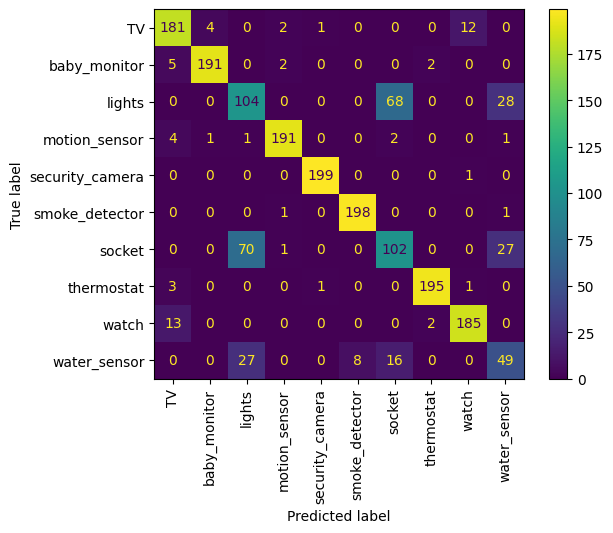

In [32]:
# Get the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_preds_named = le.inverse_transform(preds) 

mat = ConfusionMatrixDisplay.from_predictions(y, y_preds_named, xticks_rotation="vertical")
plt.show()